# Riskfolio-Lib Tutorial: 
<br>__[Financionerioncios](https://financioneroncios.wordpress.com)__
<br>__[Orenji](https://www.orenj-i.net)__
<br>__[Riskfolio-Lib](https://riskfolio-lib.readthedocs.io/en/latest/)__
<br>__[Dany Cajas](https://www.linkedin.com/in/dany-cajas/)__
<a href='https://ko-fi.com/B0B833SXD' target='_blank'><img height='36' style='border:0px;height:36px;' src='https://cdn.ko-fi.com/cdn/kofi1.png?v=2' border='0' alt='Buy Me a Coffee at ko-fi.com' /></a> 

## Tutorial 19: Mean Entropic Drawdown at Risk (EDaR) Optimization

## 1. Downloading the data:

In [ ]:
# pip install yfinance riskfolio-lib Mosek pybind11

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.2/949.2 kB 29.8 MB/s  0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached websockets-15.0.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 594.8 kB/s  0:00:13 eta 0:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.1/932.1 kB 32.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 59.1 MB/s  0:00:0

In [4]:
# Fixed data downloading code
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2025-04-21'
end = '2025-10-21'

# Tickers of assets
assets = ['ASTS', 'APP', 'WGS', 'AGX', 'RSI',  'EME', 'FIX', 'IESC',  'FICO', 'LMB', 'NVDA', 
          'PLTR', 'IREN', 'HG.CN',
          'ADUR', 'SLNH', 'CH.V', 'FCEL', 'AVGO', 'OPEN', 'NEWH']

assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)

# Check the structure of the downloaded data
print("Data columns structure:")
print(data.columns)
print("\nData shape:", data.shape)

# Handle the new yfinance data structure
if len(assets) == 1:
    # Single asset case
    data = data['Adj Close'].to_frame()
    data.columns = assets
else:
    # Multiple assets case - check if we have multi-level columns
    if isinstance(data.columns, pd.MultiIndex):
        # Extract Adj Close from multi-level columns
        if ('Adj Close',) in data.columns.levels[0]:
            data = data['Adj Close']
        else:
            # If Adj Close is not available, use Close instead
            print("Adj Close not found, using Close prices")
            data = data['Close']
    else:
        # Single level columns - check if Adj Close exists
        if 'Adj Close' in data.columns:
            data = data[['Adj Close']]
        else:
            print("Adj Close not found, using Close prices")
            data = data[['Close']]
    
    # Ensure we have the right column names
    data.columns = assets

print("\nFinal data structure:")
print(data.head())
print("\nData shape:", data.shape)


[*********************100%***********************]  21 of 21 completed

Data columns structure:
MultiIndex([( 'Close', 'ADUR'),
            ( 'Close',  'AGX'),
            ( 'Close',  'APP'),
            ( 'Close', 'ASTS'),
            ( 'Close', 'AVGO'),
            ( 'Close', 'CH.V'),
            ( 'Close',  'EME'),
            ( 'Close', 'FCEL'),
            ( 'Close', 'FICO'),
            ( 'Close',  'FIX'),
            ...
            ('Volume', 'IESC'),
            ('Volume', 'IREN'),
            ('Volume',  'LMB'),
            ('Volume', 'NEWH'),
            ('Volume', 'NVDA'),
            ('Volume', 'OPEN'),
            ('Volume', 'PLTR'),
            ('Volume',  'RSI'),
            ('Volume', 'SLNH'),
            ('Volume',  'WGS')],
           names=['Price', 'Ticker'], length=105)

Data shape: (130, 105)
Adj Close not found, using Close prices

Final data structure:
                ADUR         AGX         APP       ASTS        AVGO    CH.V  \
Date                                                                          
2025-04-21 430.0000% 129

In [5]:
# Calculating returns (fixed version)
Y = data.pct_change().dropna()

display(Y.head())

# Y.to_excel('Y_data.xlsx', index=True)


,ADUR,AGX,APP,ASTS,AVGO,CH.V,EME,FCEL,FICO,FIX,...,IESC,IREN,LMB,NEWH,NVDA,OPEN,PLTR,RSI,SLNH,WGS
Date,,,,,,,,,,,,,,,,,,,,,
2025-04-22,1.4186%,3.4547%,4.1994%,2.5765%,2.0275%,0.0000%,2.8921%,-3.1169%,3.1287%,3.7054%,...,5.8746%,9.9818%,6.4760%,22.7799%,2.0431%,6.3237%,3.5132%,2.2948%,14.9254%,6.4257%
2025-04-23,-1.8574%,5.4847%,6.1588%,5.2582%,4.3224%,11.1111%,2.9287%,0.0000%,2.8384%,4.5162%,...,5.2332%,0.6601%,4.0471%,3.7736%,3.8629%,-15.2218%,7.2667%,1.3805%,-5.1948%,9.0825%
2025-04-24,2.4533%,5.1641%,6.1542%,7.3595%,6.3535%,0.0000%,4.2928%,3.2172%,0.5581%,5.7661%,...,4.7588%,3.2787%,2.5711%,15.4545%,3.6218%,-7.6100%,6.9034%,2.2128%,15.0685%,3.5008%
2025-04-25,-1.7104%,1.9508%,3.3410%,-1.2879%,2.2110%,0.0000%,2.4013%,-0.7792%,0.8003%,5.6405%,...,2.9126%,3.8095%,-0.6320%,-3.1496%,4.3033%,-1.6731%,4.6391%,1.9983%,8.3333%,1.4809%
2025-04-28,3.4803%,0.2111%,2.9441%,2.0623%,0.0832%,20.0000%,0.0049%,5.7592%,-0.4630%,-0.7624%,...,-1.0924%,-2.2936%,-0.7654%,-9.4851%,-2.0539%,1.7016%,1.6581%,-0.0816%,-9.8901%,1.3332%


In [6]:
# Calculating returns

Y = data[assets].pct_change().dropna()

display(Y.head())

# Y.to_excel('Y_data.xlsx', index=True)

,ADUR,AGX,APP,ASTS,AVGO,CH.V,EME,FCEL,FICO,FIX,...,IESC,IREN,LMB,NEWH,NVDA,OPEN,PLTR,RSI,SLNH,WGS
Date,,,,,,,,,,,,,,,,,,,,,
2025-04-22,1.4186%,3.4547%,4.1994%,2.5765%,2.0275%,0.0000%,2.8921%,-3.1169%,3.1287%,3.7054%,...,5.8746%,9.9818%,6.4760%,22.7799%,2.0431%,6.3237%,3.5132%,2.2948%,14.9254%,6.4257%
2025-04-23,-1.8574%,5.4847%,6.1588%,5.2582%,4.3224%,11.1111%,2.9287%,0.0000%,2.8384%,4.5162%,...,5.2332%,0.6601%,4.0471%,3.7736%,3.8629%,-15.2218%,7.2667%,1.3805%,-5.1948%,9.0825%
2025-04-24,2.4533%,5.1641%,6.1542%,7.3595%,6.3535%,0.0000%,4.2928%,3.2172%,0.5581%,5.7661%,...,4.7588%,3.2787%,2.5711%,15.4545%,3.6218%,-7.6100%,6.9034%,2.2128%,15.0685%,3.5008%
2025-04-25,-1.7104%,1.9508%,3.3410%,-1.2879%,2.2110%,0.0000%,2.4013%,-0.7792%,0.8003%,5.6405%,...,2.9126%,3.8095%,-0.6320%,-3.1496%,4.3033%,-1.6731%,4.6391%,1.9983%,8.3333%,1.4809%
2025-04-28,3.4803%,0.2111%,2.9441%,2.0623%,0.0832%,20.0000%,0.0049%,5.7592%,-0.4630%,-0.7624%,...,-1.0924%,-2.2936%,-0.7654%,-9.4851%,-2.0539%,1.7016%,1.6581%,-0.0816%,-9.8901%,1.3332%


In [ ]:
# Fixed portfolio optimization code
import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:
method_mu='JS'
method_cov='gerber1'
method_kurt='semi'

# Fixed: Removed the invalid 'd' parameter
port.assets_stats(method_mu=method_mu, method_cov=method_cov, method_kurt=method_kurt)

# Estimate optimal portfolio:

# port.solvers = ['MOSEK'] # It is recommended to use mosek when optimizing EVaR 
port.alpha = 0.01 # Significance level for CVaR, EVaR y CDaR 
model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'EDaR' # Risk measure used, this time will be EDaR
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

print(w.sort_values(by='weights', ascending=False).to_string(index=True))


## 2. Estimating Mean EDaR Portfolios

### 2.1 Calculating the portfolio that maximizes Return/EDaR ratio.

The Entropic Drawdown at Risk (EDaR) is a risk measure derived from Entropic Value at Risk, that I developed when you apply the EVaR to drawdowns distribution:

$$
\begin{aligned}
\text{EVaR}_{\alpha}(X) & = \inf_{z>0} \left \{z\log \left ( \frac{1}{\alpha} M_{\text{DD}(X)} (\frac{1}{z}) \right ) \right \} \\
\text{DD}(X,j) & = \max_{t \in (0,j)} \left ( \sum_{i=0}^{t}X_{i} \right )- \sum_{i=0}^{j}X_{i} \\
\end{aligned}
$$

Where $M_{X} (t) = \text{E} [e^{tX}]$ is the moment generating function and $\alpha \in [0,1]$ is the significance level.
    
In a similar way than Markowitz model, the mean EDaR model can be expressed as one of the following problems:

$$
\begin{aligned}
& \min_{w,\, z} & & \mu w - \lambda \text{EDaR}_{\alpha}(r w)\\
& & & 1^{T}w = 1 \\
& & & w \geq 0 \\
\end{aligned}
$$

$$
\begin{aligned}
& \max_{w,\, z} & & \frac{\mu w - r_{f}}{\lambda \text{EDaR}_{\alpha}(r w)}\\
& & & 1^{T}w = 1 \\
& & & w \geq 0 \\
\end{aligned}
$$

$$
\begin{aligned}
& \min_{w,\, z} & & \text{EDaR}_{\alpha}(r w)\\
& & & 1^{T}w = 1 \\
& & & w \geq 0 \\
\end{aligned}
$$

Where $z$ is the factor of EDaR, $w$ are the weights of assets, $\mu$ is the mean vector, $\lambda$ is the risk aversion factor, $r$ is the returns matrix and $r_{f}$ the risk free rate.

It is recommended to use MOSEK to optimize EDaR, due to it requires exponential cone programming to solve the problem.

Instructions to install MOSEK are in this __[link](https://docs.mosek.com/9.2/install/installation.html)__, is better to install using Anaconda. Also you will need a license, I recommend you that ask for an academic license __[here](https://www.mosek.com/products/academic-licenses/)__.

In [9]:
import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='JS'
method_cov='gerber1'
method_kurt='semi'

port.assets_stats(method_mu=method_mu, method_cov=method_cov, method_kurt=method_kurt)

# Estimate optimal portfolio:

# port.solvers = ['MOSEK'] # It is recommended to use mosek when optimizing EVaR 
port.alpha = 0.01 # Significance level for CVaR, EVaR y CDaR 
model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'EDaR' # Risk measure used, this time will be EDaR
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

print(w.sort_values(by='weights', ascending=False).to_string(index=True))

       weights
FIX   64.9176%
IREN  11.1114%
EME    7.6424%
FICO   6.7235%
NVDA   5.4536%
CH.V   1.9680%
ASTS   1.1369%
OPEN   0.8896%
RSI    0.1436%
SLNH   0.0134%
LMB    0.0000%
AVGO   0.0000%
NEWH   0.0000%
WGS    0.0000%
IESC   0.0000%
FCEL   0.0000%
APP    0.0000%
PLTR   0.0000%
ADUR   0.0000%
AGX    0.0000%
HG.CN  0.0000%


### 2.2 Plotting portfolio composition

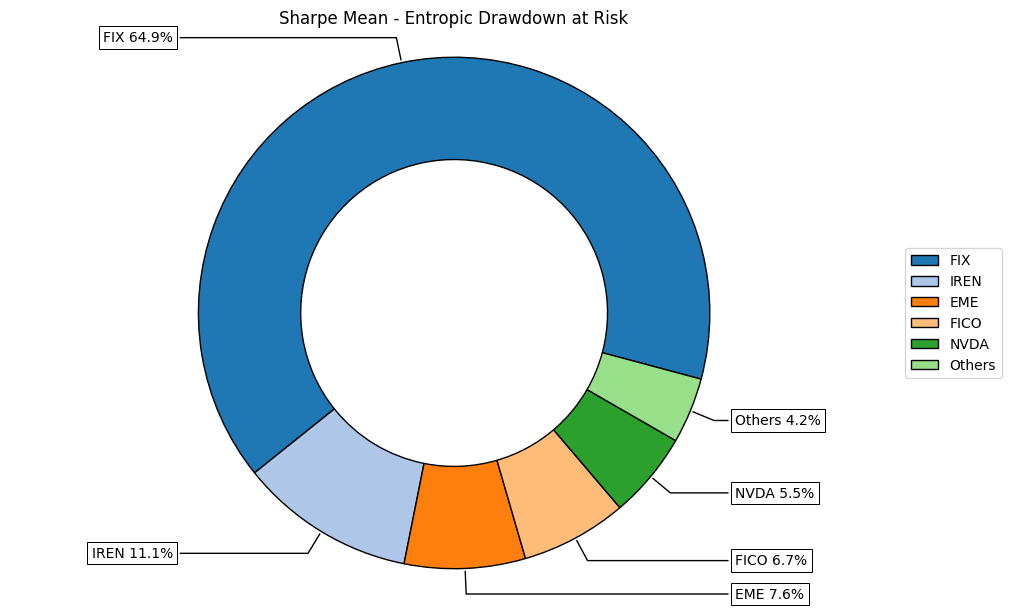

In [10]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w, title='Sharpe Mean - Entropic Drawdown at Risk', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

### 2.3 Plotting risk measures

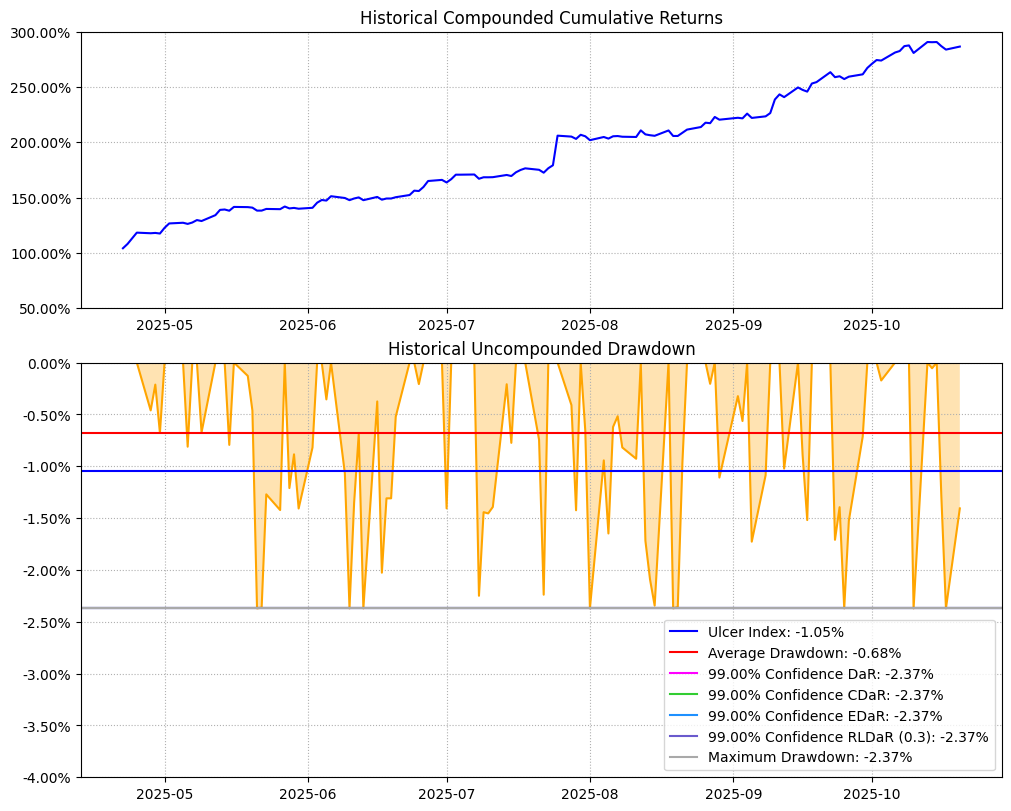

In [11]:
# Plotting the drawdown risk measures

ax = rp.plot_drawdown(returns=Y,
                      w=w,
                      alpha=0.01,
                      height=8,
                      width=10,
                      height_ratios=[2, 3],
                      ax=None)

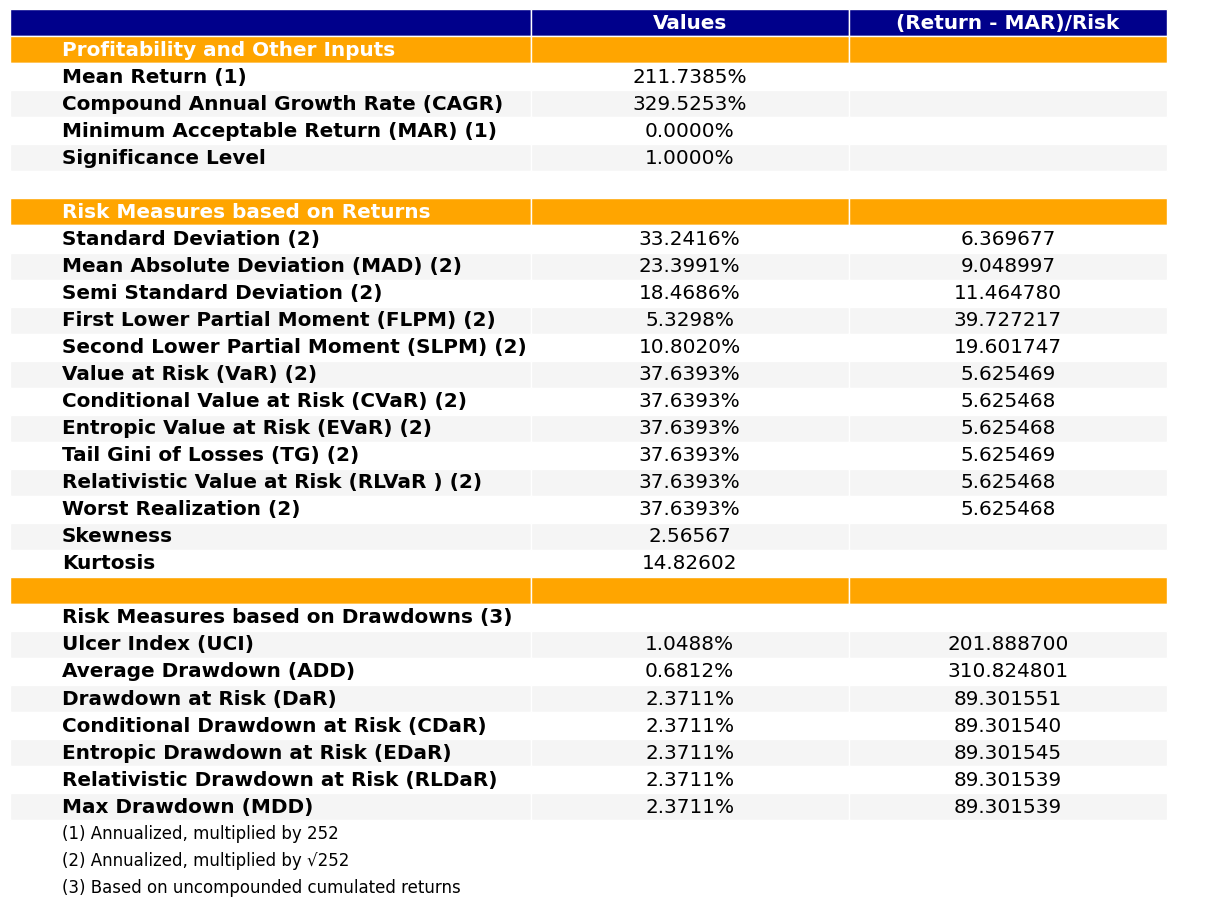

In [12]:
ax = rp.plot_table(returns=Y,
                   w=w,
                   MAR=0,
                   alpha=0.01,
                   ax=None)

### 2.4 Calculate efficient frontier

In [13]:
points = 40 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T)

,ADUR,AGX,APP,ASTS,AVGO,CH.V,EME,FCEL,FICO,FIX,...,IESC,IREN,LMB,NEWH,NVDA,OPEN,PLTR,RSI,SLNH,WGS
0,0.0000%,0.0000%,0.0000%,0.0000%,1.6543%,3.8689%,62.6646%,0.0000%,3.1140%,0.0000%,...,0.0000%,9.6900%,0.1330%,0.0000%,13.3315%,0.6550%,0.0000%,4.1467%,0.7420%,0.0000%
1,0.9334%,0.0000%,0.0000%,0.3190%,0.0000%,2.0996%,0.0000%,0.0000%,0.0000%,69.1559%,...,0.0000%,19.9601%,0.0000%,0.0000%,0.0000%,6.5214%,0.0000%,0.0000%,0.9618%,0.0000%
2,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,3.7964%,0.0000%,0.0000%,0.0000%,50.3142%,...,0.0000%,30.6970%,0.0000%,0.0000%,0.0000%,11.9437%,0.0000%,0.0000%,1.7615%,0.0000%
3,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,4.7133%,0.0000%,0.0000%,0.0000%,31.3235%,...,0.0000%,41.4909%,0.0000%,0.0000%,0.0000%,17.0229%,0.0000%,0.0000%,2.5388%,0.0000%
4,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,2.5584%,0.0000%,0.0000%,0.0000%,16.6388%,...,0.0000%,51.9161%,0.0000%,0.0000%,0.0000%,22.0081%,0.0000%,0.0000%,1.8743%,0.0000%
5,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,2.3801%,0.0000%,0.0000%,0.0000%,5.3121%,...,0.0000%,58.3341%,0.0000%,0.0000%,0.0000%,24.0180%,0.0000%,0.0000%,0.6547%,0.0000%
6,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,...,0.0000%,58.8709%,0.0000%,0.0000%,0.0000%,29.1087%,0.0000%,0.0000%,0.0000%,0.0000%
7,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,...,0.0000%,47.8616%,0.0000%,0.0000%,0.0000%,38.9850%,0.0000%,0.0000%,0.0000%,0.0000%
8,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,...,0.0000%,38.3721%,0.0000%,0.0000%,0.0000%,46.5525%,0.0000%,0.0000%,0.0000%,0.0000%
9,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,...,0.0000%,31.8278%,0.0000%,0.0000%,0.0000%,48.5919%,0.0000%,0.0000%,0.0000%,0.0000%


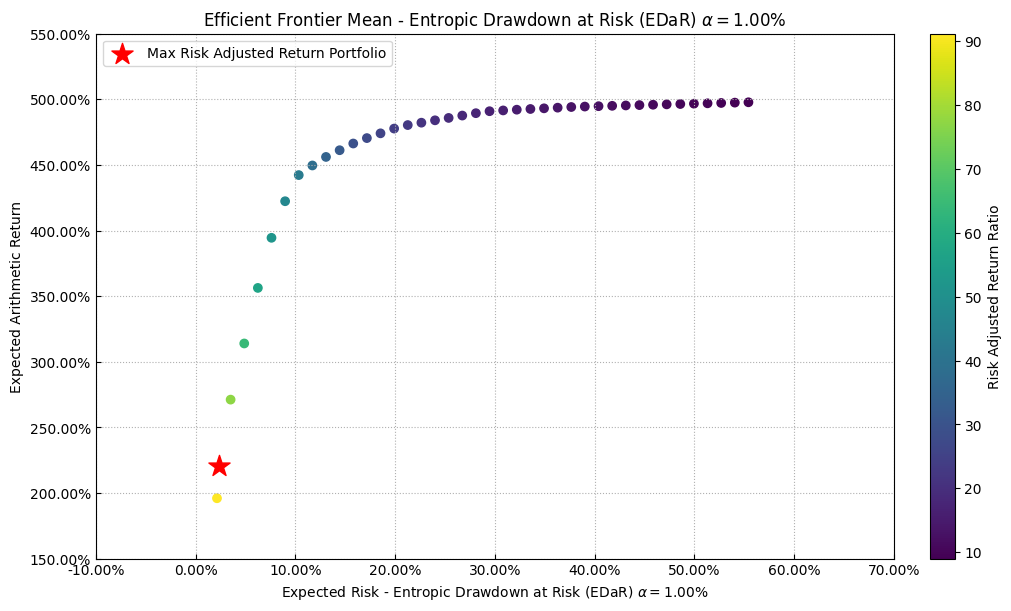

In [14]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.01, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

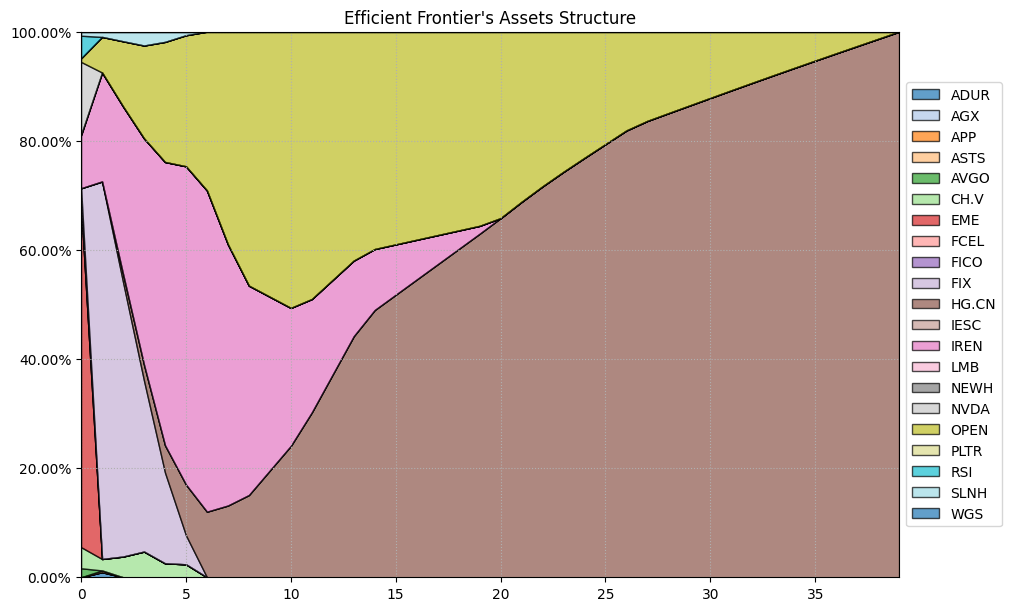

In [15]:
# Plotting efficient frontier composition

ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

      weights   value
IREN   58.87%  58,871
OPEN   29.11%  29,109
HG.CN  12.02%  12,020
SLNH    0.00%       0
CH.V    0.00%       0
ADUR    0.00%       0
ASTS    0.00%       0
FIX     0.00%       0
AGX     0.00%       0
APP     0.00%       0
IESC    0.00%       0
FCEL    0.00%       0
EME     0.00%       0
AVGO    0.00%       0
NVDA    0.00%       0
RSI     0.00%       0
WGS     0.00%       0
PLTR    0.00%       0
LMB     0.00%       0
NEWH    0.00%       0
FICO    0.00%       0


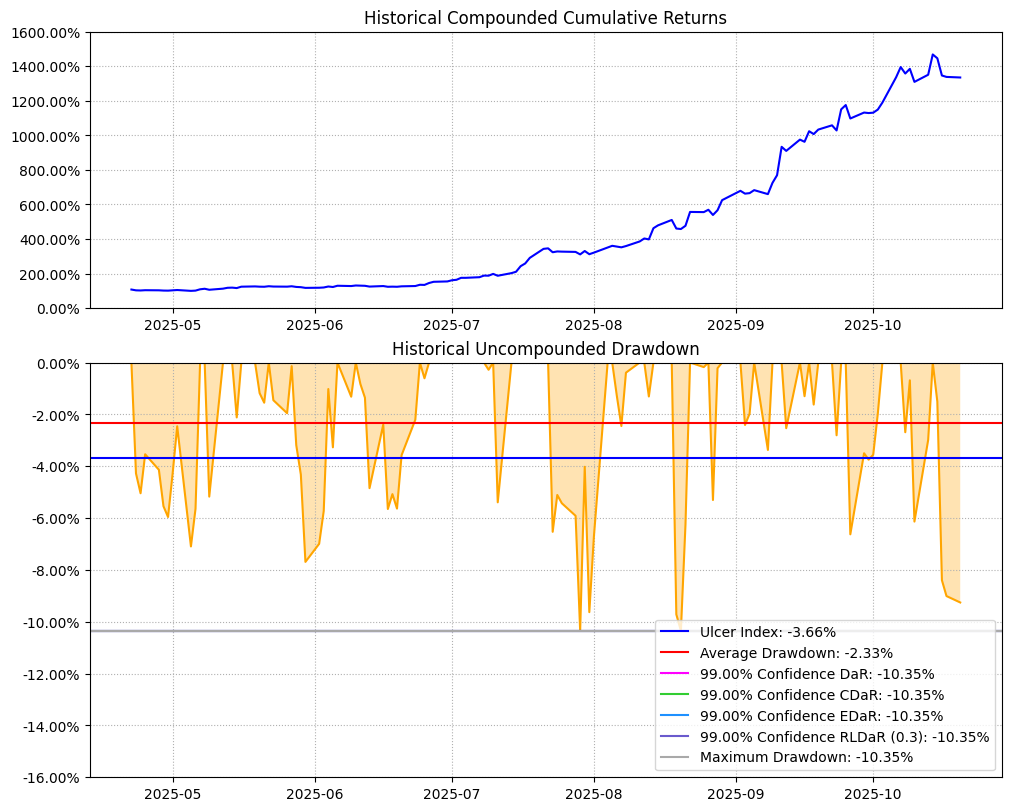

In [16]:
# Plotting the drawdown risk measures

portfolio_value = 100000

w_index = 6
w = frontier.T.loc[w_index].to_frame().T.rename(index={w_index: 'weights'}).T

# w_target = {
#   'DRO.AX': 0.31,
#   'WGS': 0.214,
#   'INSG': 0.195,
#   'EBS': 0.144,
#   'AEYE': 0.138,
# }

# w['weights'] = 0

# for asset, weight in w_target.items():
#     w['weights'][asset] = weight

ax = rp.plot_drawdown(returns=Y,
                      w=w,
                      alpha=0.01,
                      height=8,
                      width=10,
                      height_ratios=[2, 3],
                      ax=None)
w_sorted = w
w_sorted = w.sort_values(by='weights', ascending=False)
w_sorted['value'] = w_sorted['weights'] * portfolio_value
w_sorted['weights'] = w_sorted['weights'].apply(lambda x: f'{x:.2%}')
w_sorted['value'] = w_sorted['value'].apply(lambda x: f'{x:,.0f}')

print(w_sorted.to_string(index=True))

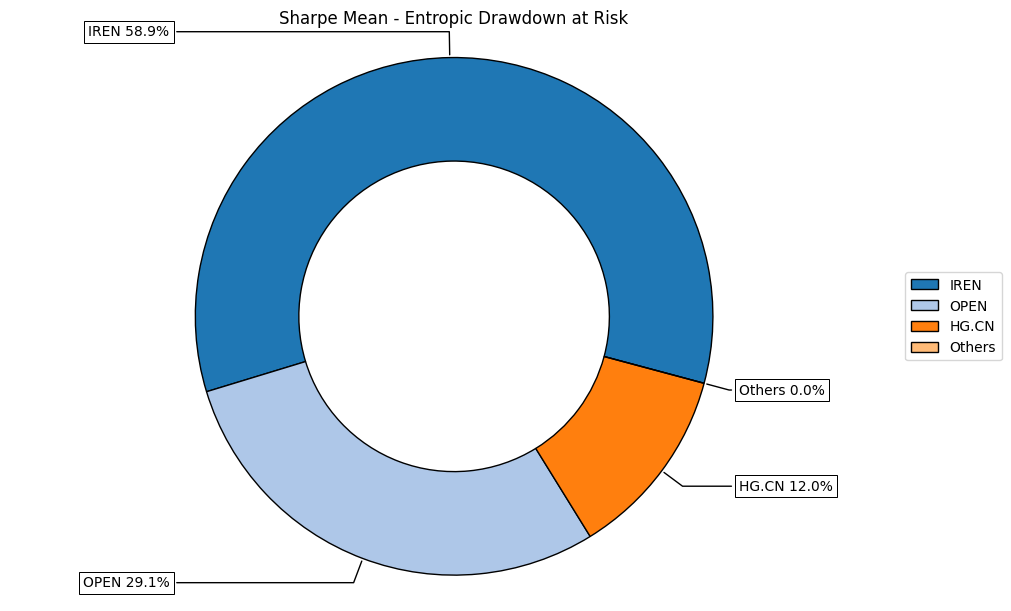

In [17]:
ax = rp.plot_pie(w=w, title='Sharpe Mean - Entropic Drawdown at Risk', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

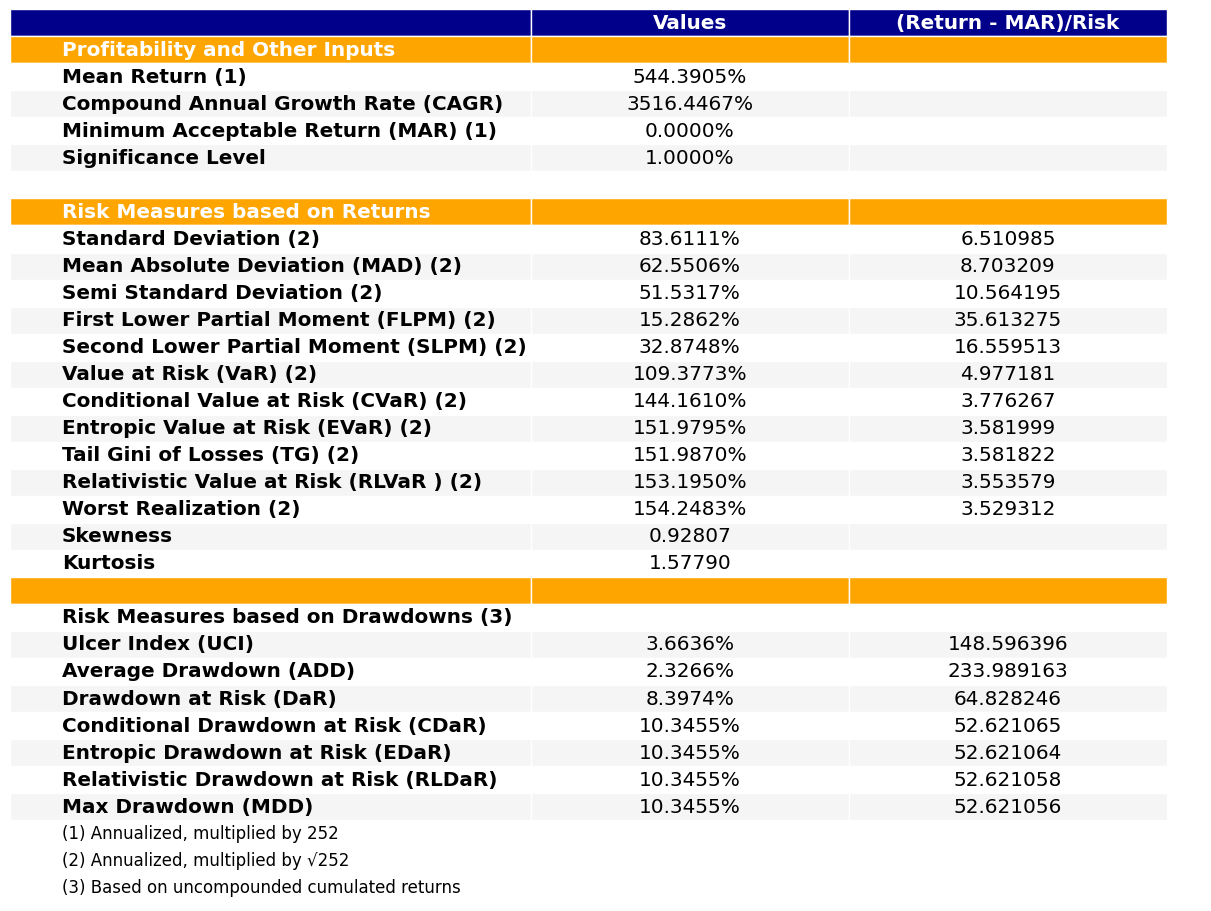

In [18]:
ax = rp.plot_table(returns=Y,
                   w=w,
                   MAR=0,
                   alpha=0.01,
                   ax=None)